In [1]:
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import numpy as np
import datetime as dt

/home/dlhogan/.conda/envs/soil_moisture_env/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.11.1-CAPI-1.17.1). Conversions between both will be slow.
  warnings.warn(


### This notebook will create plots for naturalized streamflow, precipitation, and temperatures across the UCRB

In [2]:
# import UCRB precipitation
#EPSG code
co_epsg = 32613

# pull in UCRB basin 
ucrb_basin_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(co_epsg)

In [3]:
if not os.path.exists('../data/precipdata/prism_4km_ucrb.nc'):
       # Download PRISM precipitation from 4km product 
       outpath = '../data/precipdata/PRISM/PRISM_ppt_stable_4km/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 37)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry)
              prism_list.append(tmp)
       prism_4km_ds = xr.concat(prism_list, dim='band')
       prism_4km_ds = prism_4km_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_ds = prism_4km_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 

       # Filter to correct dates
       prism_4km_ds = prism_4km_ds.sortby('month')
       prism_4km_ds = prism_4km_ds.sel(month=slice('1981-01-01', '2022-09-01'))

In [4]:
# Download historic PRISM precipitation from 4km product 
if not os.path.exists('../data/precipdata/prism_4km_ucrb.nc'):
       outpath = '/storage/dlhogan/sos/data/PRISM_ppt/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 37)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry)
              prism_list.append(tmp)
       prism_4km_historic_ds = xr.concat(prism_list, dim='band')
       prism_4km_historic_ds = prism_4km_historic_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_historic_ds = prism_4km_historic_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 
       prism_4km_historic_ds = prism_4km_historic_ds.sortby('month')
       prism_4km_all_ds = xr.concat([prism_4km_historic_ds, prism_4km_ds], dim='month')
       prism_4km_all_ds.to_netcdf('../data/precipdata/prism_4km_ucrb.nc')
else:
       prism_4km_all_ds = xr.open_dataset('../data/precipdata/prism_4km_ucrb.nc')

In [5]:
if not os.path.exists('../data/etdata/prism_tmean_4km_ucrb.nc'):
       # Download PRISM precipitation from 4km product 
       outpath = '/storage/dlhogan/sos/data/PRISM/'
       files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and (len(x) == 39)]
       prism_list = []
       dates = []
       for file in files:
              dates.append(file[-14:-8]+'01')
              tmp = rxr.open_rasterio(os.path.join(outpath,file)).rio.reproject(co_epsg).rio.clip(ucrb_basin_boundary.geometry)
              prism_list.append(tmp)
       prism_4km_tmean_ds = xr.concat(prism_list, dim='band')
       prism_4km_tmean_ds = prism_4km_tmean_ds.rename({'band':'month'})

       # Assign dates to coordinates
       prism_4km_tmean_ds = prism_4km_tmean_ds.assign_coords({
              'month': pd.to_datetime(dates,format='%Y%m%d')}) 

       # Filter to correct dates
       prism_4km_tmean_ds = prism_4km_tmean_ds.sortby('month')
       prism_4km_tmean_ds = prism_4km_tmean_ds.sel(month=slice('1895-01-01', '2022-09-01'))

       prism_4km_tmean_ds.to_netcdf('../data/etdata/prism_tmean_4km_ucrb.nc')
else:
       prism_4km_tmean_ds = xr.open_dataset('../data/etdata/prism_tmean_4km_ucrb.nc')

# Import naturalized streamflow

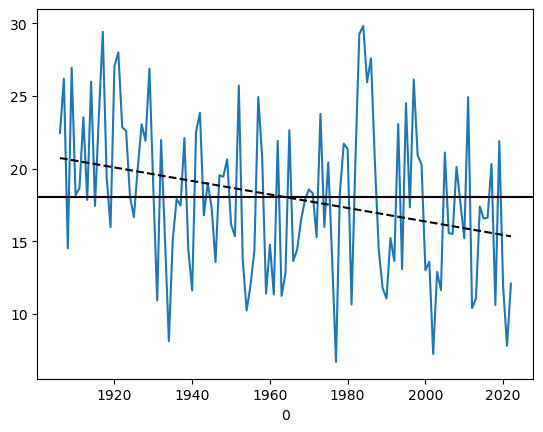

In [6]:

ucrb_naturalized_streamflow = pd.read_csv('../data/streamflowdata/LF_NATURALIZED_FLOW.csv', header=None, index_col=0)
ucrb_naturalized_streamflow = ucrb_naturalized_streamflow.rename(columns={1:'annual_flow_km3'}) * 1.23348e-6
ucrb_naturalized_streamflow['q_mm_day'] = ucrb_naturalized_streamflow['annual_flow_km3'] * 1e9 / 365 /ucrb_basin_boundary.area.values[0] * 1000
ucrb_naturalized_streamflow['annual_flow_anom'] = (ucrb_naturalized_streamflow['annual_flow_km3']-ucrb_naturalized_streamflow['annual_flow_km3'].mean())/ucrb_naturalized_streamflow['annual_flow_km3'].std()
slope1, intercept1, _,_,_ = stats.linregress(ucrb_naturalized_streamflow.index,ucrb_naturalized_streamflow['annual_flow_km3'].values)
ucrb_naturalized_streamflow['annual_flow_km3'].plot()
plt.plot(ucrb_naturalized_streamflow.index , slope1*ucrb_naturalized_streamflow.index + intercept1, ls='--',color='k')
plt.axhline(ucrb_naturalized_streamflow['annual_flow_km3'].mean(), color='k')

In [7]:
p_mean = prism_4km_all_ds.where(prism_4km_all_ds>0).mean(dim=['x','y'])
p_mean['WY'] = p_mean.month.dt.year.where(p_mean.month.dt.month<10, p_mean.month.dt.year+1)
annual_p_sum = p_mean.groupby('WY').sum()
annual_p_km3 = (annual_p_sum / 1000) * np.full(len(annual_p_sum.WY), ucrb_basin_boundary.area) / 1e9
annual_p_km3 = annual_p_km3.sel(WY=slice(1896,2022))
annual_p_km3 = annual_p_km3.rename({'__xarray_dataarray_variable__':'p_km3'})

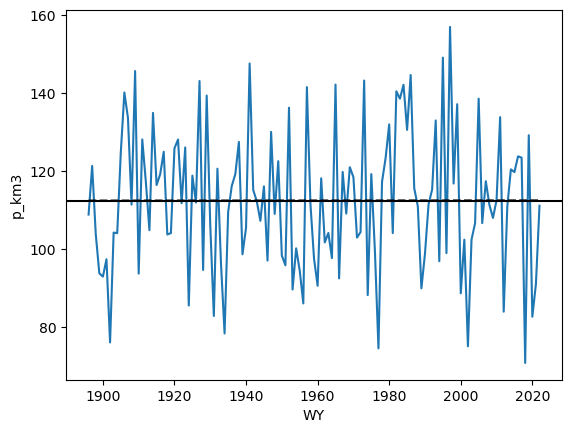

In [8]:
slope2, intercept2, _,_,_ = stats.linregress(annual_p_km3.WY,annual_p_km3['p_km3'].values)
annual_p_km3['p_km3'].plot()
plt.plot(annual_p_km3.WY , slope2*annual_p_km3.WY + intercept2, ls='--',color='k')
plt.axhline(annual_p_km3['p_km3'].mean(), color='k')

In [9]:
t_mean = prism_4km_tmean_ds.where(prism_4km_tmean_ds>-100).mean(dim=['x','y'])
t_mean['WY'] = t_mean.month.dt.year.where(t_mean.month.dt.month<10, t_mean.month.dt.year+1)
annual_t_mean = t_mean.groupby('WY').mean()
annual_t_mean = annual_t_mean.rename({'__xarray_dataarray_variable__':'t_mean'})
annual_t_mean = annual_t_mean.sel(WY=slice(1896,2022))


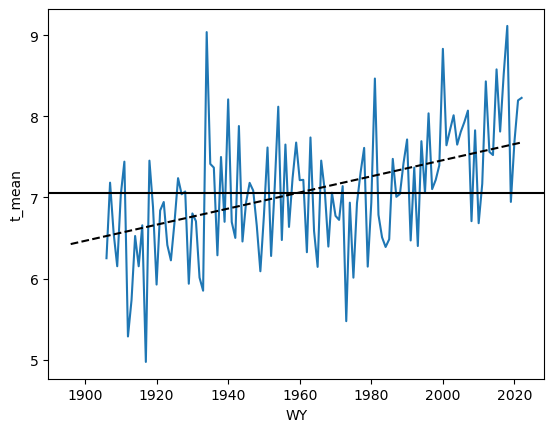

In [10]:
slope3, intercept3, _,_,_ = stats.linregress(annual_t_mean.WY,annual_t_mean['t_mean'].values)
annual_t_mean['t_mean'].sel(WY=slice(1906,2022)).plot()
plt.plot(annual_t_mean.WY , slope3*annual_t_mean.WY + intercept3, ls='--',color='k')
plt.axhline(annual_t_mean['t_mean'].mean(), color='k')

Plot all three together

In [11]:
drought_1930s = pd.date_range('1932-09-01','1936-08-31', freq='1M')
drought_1970s = pd.date_range('1976-09-01','1981-08-31',freq='1M')
drought_1980s = pd.date_range('1988-09-01','1993-08-31',freq='1M')
drought_2000s = pd.date_range('2000-09-01','2005-08-31',freq='1M')
drought_2010s = pd.date_range('2017-09-01','2022-08-31',freq='1M')
all_dates = pd.date_range('1895-10-01','2022-10-01', freq='1Y')

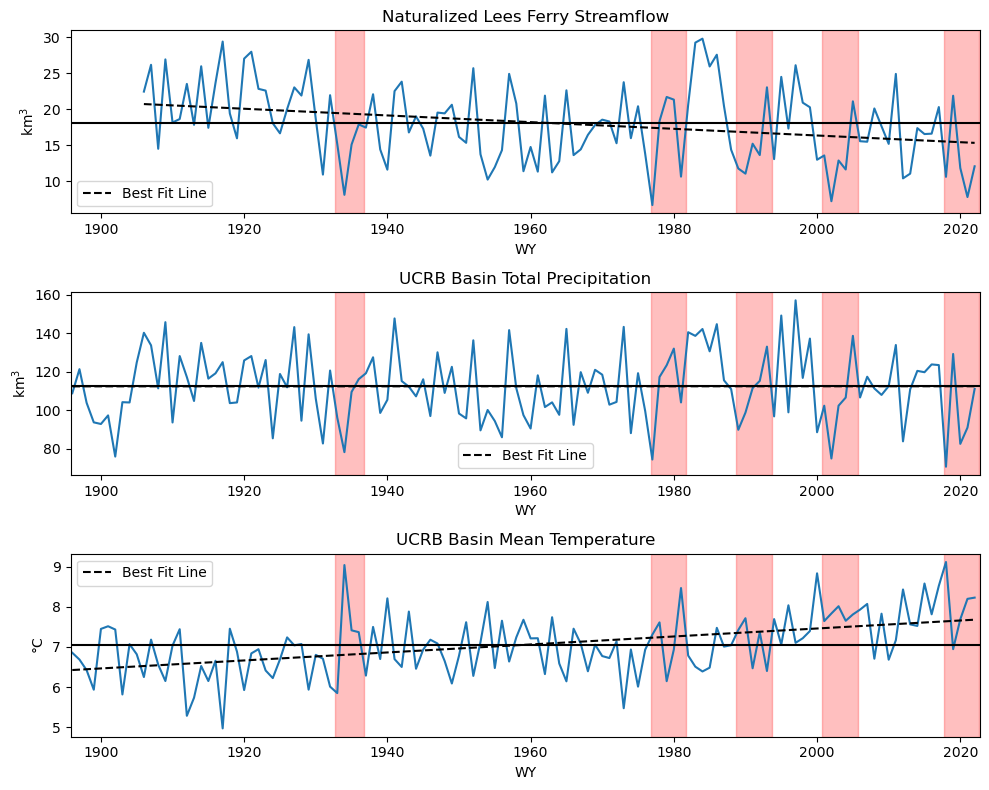

In [12]:
fig, axs = plt.subplots(nrows=3, figsize=(10,8), tight_layout=True)

ax = axs[0]
ax.plot(all_dates[10:] , ucrb_naturalized_streamflow['annual_flow_km3'])
ax.plot(all_dates[10:] , slope1*ucrb_naturalized_streamflow.index + intercept1, ls='--',color='k', label='Best Fit Line')
ax.axhline(ucrb_naturalized_streamflow['annual_flow_km3'].mean(), color='k')
ax.set_ylabel('km$^3$')
ax.set_title('Naturalized Lees Ferry Streamflow')
ax.set_xlim()

ax = axs[1]
ax.plot(all_dates,annual_p_km3['p_km3'].values)
ax.plot(all_dates , slope2*annual_p_km3.WY + intercept2, ls='--',color='k', label='Best Fit Line')
ax.axhline(annual_p_km3['p_km3'].mean(), color='k')
ax.set_ylabel('km$^3$')
ax.set_title('UCRB Basin Total Precipitation')

ax = axs[2]
ax.plot(all_dates,annual_t_mean['t_mean'].values)
ax.plot(all_dates , slope3*annual_t_mean.WY + intercept3, ls='--',color='k', label='Best Fit Line')
ax.axhline(annual_t_mean['t_mean'].mean(), color='k')
ax.set_ylabel('$\degree$C')
ax.set_title('UCRB Basin Mean Temperature')
for ax in axs:
    for drought in [drought_1930s,drought_1970s,drought_1980s,drought_2000s,drought_2010s]:
        ax.axvspan(drought[0],drought[-1],color='red',alpha=0.25)
        ax.legend()
        ax.set_xlabel('WY')
        ax.set_xlim(dt.date(1895,10,1),dt.date(2022,10,1))

### Do I want to make a snow model for SMRI?

In [40]:
hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json')
hcdn_basins = hcdn_basins.set_index('gage')

In [41]:
area_da = hcdn_basins.basin_area.to_xarray()
area_da = area_da.rename({'gage':'site_no'})

In [42]:
ucrb_dem = rxr.open_rasterio('../basin_characteristics/ucrb_dem_150m.tif')
basin_mean_elevations = {}
for gage in hcdn_basins.index:
    basin = hcdn_basins[hcdn_basins.index==gage]
    clipped_dem = ucrb_dem.rio.clip(basin.geometry).squeeze()
    clipped_dem_ma = clipped_dem.where(clipped_dem>0)
    basin_mean_elevations[gage] = clipped_dem_ma.mean().values

In [43]:
elevation_da = xr.Dataset(basin_mean_elevations).to_array()
elevation_da.name='elevation'
elevation_da = elevation_da.rename({'variable':'site_no'})

In [44]:
ucrb_aspect = rxr.open_rasterio('../basin_characteristics/ucrb_aspect.tif')
basin = hcdn_basins[hcdn_basins.index==gage]
clipped_aspect = ucrb_aspect.rio.clip(basin.geometry).squeeze()
clipped_aspect_ma = clipped_aspect.where(clipped_aspect>=0)
north = clipped_aspect_ma.where((clipped_aspect_ma>=315) | (clipped_aspect_ma<45))
west = clipped_aspect_ma.where((clipped_aspect_ma>=225) & (clipped_aspect_ma<315))
south = clipped_aspect_ma.where((clipped_aspect_ma>=135) & (clipped_aspect_ma<225))
east = clipped_aspect_ma.where((clipped_aspect_ma>=45) & (clipped_aspect_ma<135))

In [55]:
seconds_per_day = 3600 * 24
cubic_ft_to_m = 35.315
hcdn_streamflow_ds = xr.open_dataset('../data/streamflowdata/hcdn_q_data.nc')
hcdn_streamflow_ds['site_no'] = ['0'+str(site) for site in hcdn_streamflow_ds['site_no'].values]
hcdn_streamflow_ds = hcdn_streamflow_ds.merge(area_da)
hcdn_streamflow_ds = hcdn_streamflow_ds.merge(elevation_da)
hcdn_streamflow_ds['q_mm_day'] = hcdn_streamflow_ds['00060_Mean'] * seconds_per_day/cubic_ft_to_m /hcdn_streamflow_ds.basin_area

hcdn_q_spring_summer_ds = hcdn_streamflow_ds.where(hcdn_streamflow_ds.date.dt.month.isin([4,5,6,7,8,9])).to_dataframe().dropna().to_xarray()
hcdn_q_spring_summer_ds = hcdn_q_spring_summer_ds.sortby('date')
hcdn_q_spring_summer_mean_ds = hcdn_q_spring_summer_ds.groupby('date.year').mean()
hcdn_q_spring_summer_norm = (hcdn_q_spring_summer_mean_ds-hcdn_q_spring_summer_mean_ds.mean(dim='year'))/hcdn_q_spring_summer_mean_ds.std(dim='year')

<xarray.Dataset>
Dimensions:     (site_no: 29, year: 118)
Coordinates:
  * site_no     (site_no) object '09034900' '09035900' ... '09378170' '09378630'
  * year        (year) int64 1902 1903 1904 1905 1906 ... 2019 2020 2021 2022
Data variables:
    00060_Mean  (year, site_no) float64 nan nan nan ... -1.162 -0.5497 -0.7941
    WY          (year, site_no) float64 nan nan nan nan ... 1.71 1.686 1.702
    basin_area  (year, site_no) float64 nan nan nan nan ... -1.0 0.9969 1.0 1.0
    elevation   (year, site_no) float32 nan nan nan nan ... nan -1.004 -1.0 1.0
    q_mm_day    (year, site_no) float64 nan nan nan ... -1.162 -0.5497 -0.7941

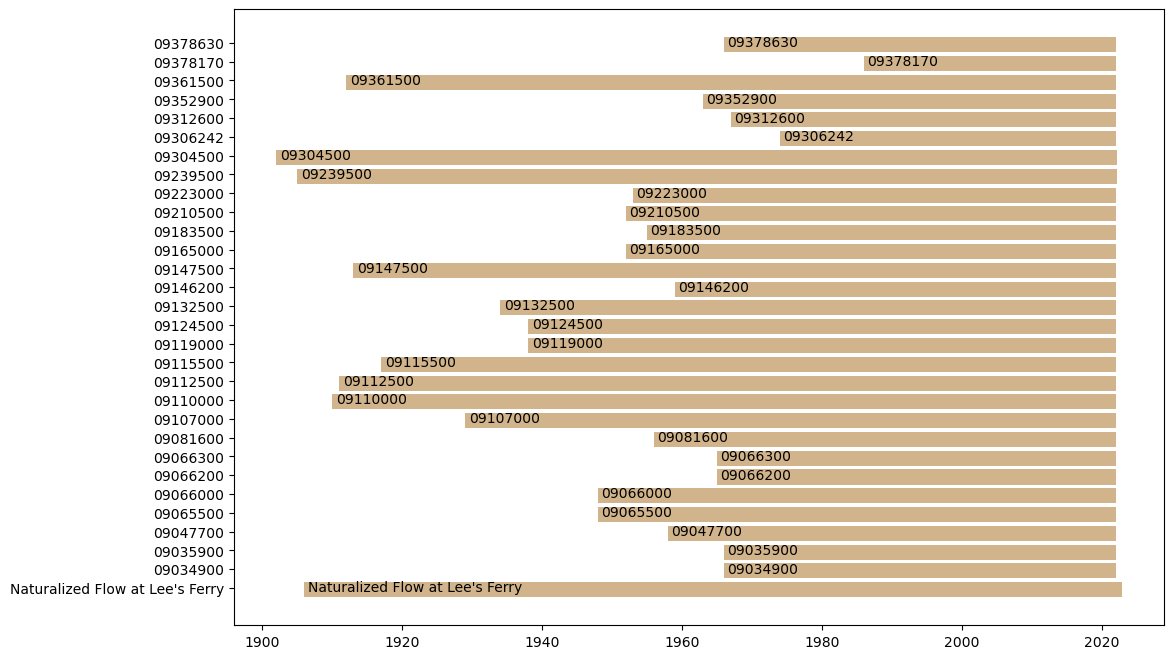

In [46]:
source = pd.DataFrame([{"data": "Naturalized Flow at Lee's Ferry","start": '1906-01-01', "end": '2022-09-30'},])
for i,site in enumerate(hcdn_q_spring_summer_mean_ds.site_no):
    min_year = int(hcdn_q_spring_summer_mean_ds.sel(site_no=site).WY.min().values)
    max_year = int(hcdn_q_spring_summer_mean_ds.sel(site_no=site).WY.max().values)
    source.loc[i+1] = {"data": str(site.values),"start": f'{min_year}-09-30', "end": f'{max_year}-10-01'}

source['start'] = pd.to_datetime(source['start'])
source['end'] = pd.to_datetime(source['end'])
source['diff'] = source['end'] - source['start']
 
# Declaring a figure "gnt"
fig, ax = plt.subplots(figsize=(12,8))
gnt=ax 
# Need to fix hidden tick labels
# https://stackoverflow.com/questions/43673659/matplotlib-not-showing-first-label-on-x-axis-for-the-bar-plot
 
y_tick_labels = source.data.values
y_pos = np.arange(len(y_tick_labels))
 
gnt.set_yticks(y_pos)
gnt.set_yticklabels(y_tick_labels)
 
 
# https://sparkbyexamples.com/python/iterate-over-rows-in-pandas-dataframe/
# https://www.tutorialspoint.com/plotting-dates-on-the-x-axis-with-python-s-matplotlib
# https://matplotlib.org/stable/gallery/color/named_colors.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
# https://www.geeksforgeeks.org/how-to-annotate-matplotlib-scatter-plots
for index, row in source.sort_values(by='start', ascending=True).iterrows():
    start_year = int(row.start.strftime("%Y"))
    duration = row['diff'].days/365
    gnt.broken_barh([(start_year, duration)], 
                    (index-0.5,0.8), 
                    facecolors =('tan'),
                   label=row.data)
    gnt.text(start_year+0.5, index-0.2, row.data)

<AxesSubplot: xlabel='site_no', ylabel='site_no'>

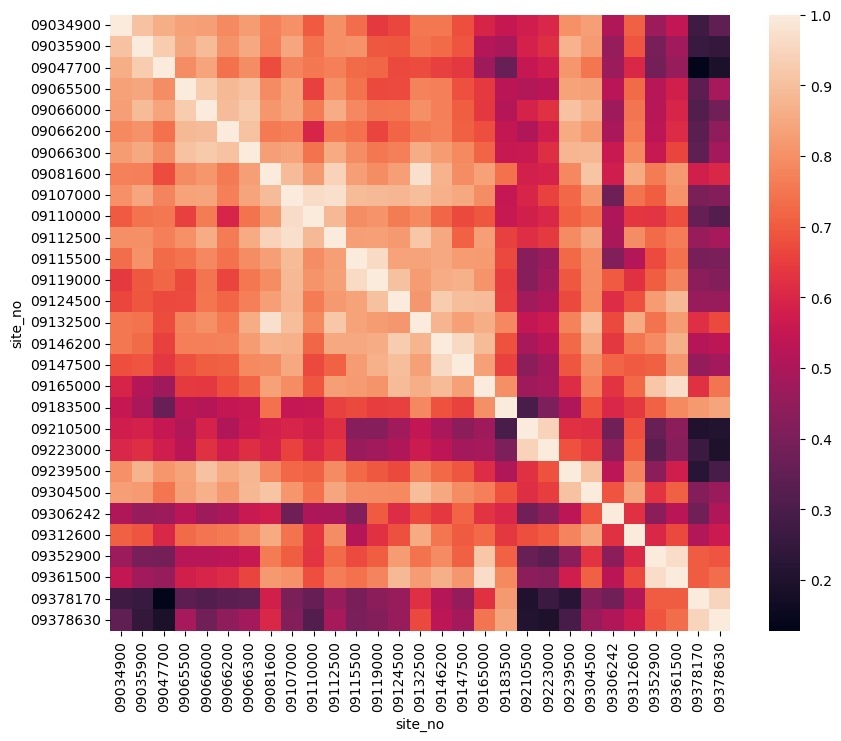

In [47]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(hcdn_q_spring_summer_mean_ds['00060_Mean'].to_pandas().corr(), ax=ax)

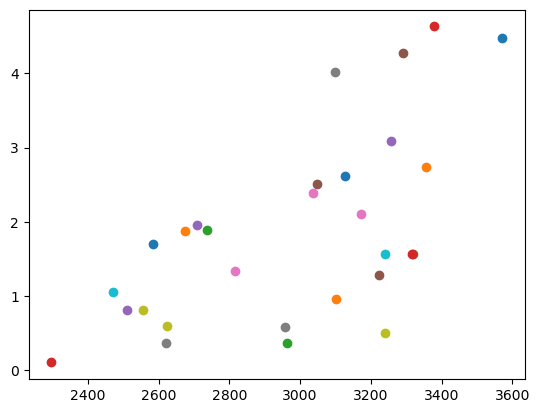

In [49]:
fig, ax = plt.subplots()
for site in hcdn_streamflow_ds.site_no:
    ax.scatter(hcdn_streamflow_ds['elevation'].sel(site_no=site).values,hcdn_streamflow_ds['q_mm_day'].sel(site_no=site).mean().values)
# ax.scatter(ucrb_basin_boundary.area, (ucrb_naturalized_streamflow['annual_flow_km3'] * 1e9 / 365 / ucrb_basin_boundary.area.values[0] * 1000).mean())

# Plot winter and spring precipitation against naturalized streamflow

In [273]:
winter_spring_p = p_mean.where(p_mean.month.dt.month.isin([12,1,2,3,4,5])).groupby('WY').sum().sel(WY=slice(1906,2022))
winter_spring_p_stand_anom = (winter_spring_p-winter_spring_p.mean())/winter_spring_p.std()

winter_p = p_mean.where(p_mean.month.dt.month.isin([12,1,2])).groupby('WY').sum().sel(WY=slice(1906,2022))
winter_p_stand_anom = (winter_p-winter_p.mean())/winter_p.std()

spring_p = p_mean.where(p_mean.month.dt.month.isin([3,4,5])).groupby('WY').sum().sel(WY=slice(1906,2022))
spring_p_stand_anom = (spring_p-spring_p.mean())/spring_p.std()

summer_p = p_mean.where(p_mean.month.dt.month.isin([6,7,8])).groupby('WY').sum().sel(WY=slice(1906,2022))
summer_p_stand_anom = (summer_p-summer_p.mean())/summer_p.std()

In [267]:
drought_1930s = slice(1932,1936)
drought_1970s = slice(1976,1981)
drought_1980s = slice(1988,1993)
drought_2000s = slice(2000,2005)
drought_2010s = slice(2018,2022)

In [268]:
def precipFlowLinReg(p, q, alternative='greater'):
    slope, intercept,r,_,_ = stats.linregress(p,q)
    return slope, intercept,r

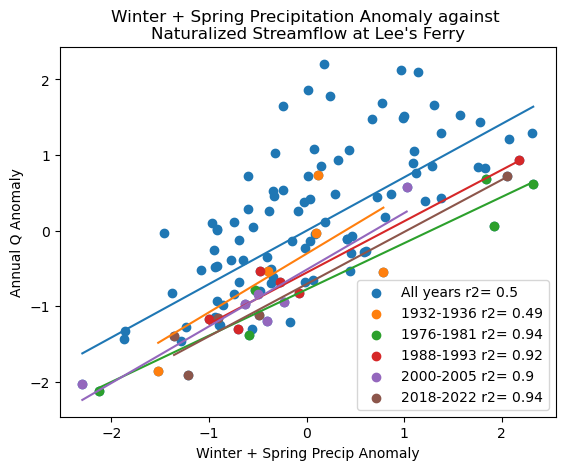

In [286]:
fig, ax = plt.subplots()
labels = ['1932-1936','1976-1981','1988-1993','2000-2005','2018-2022']

# Plot all points and trend-line
m,b,r = precipFlowLinReg(winter_spring_p_stand_anom['__xarray_dataarray_variable__'], (ucrb_naturalized_streamflow['annual_flow_anom']))
x = [winter_spring_p_stand_anom['__xarray_dataarray_variable__'].min(),winter_spring_p_stand_anom['__xarray_dataarray_variable__'].max()]
y = [winter_spring_p_stand_anom['__xarray_dataarray_variable__'].min()*m+b,winter_spring_p_stand_anom['__xarray_dataarray_variable__'].max()*m+b]
ax.plot(x,y)
ax.scatter(winter_spring_p_stand_anom['__xarray_dataarray_variable__'], (ucrb_naturalized_streamflow['annual_flow_anom']), label=f'All years r2= {round(r**2,2)}')

# Plot drought periods and trend lines
for i,drought in enumerate([drought_1930s,drought_1970s,drought_1980s,drought_2000s,drought_2010s]):
    m,b,r = precipFlowLinReg(winter_spring_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'], (ucrb_naturalized_streamflow.loc[drought]['annual_flow_anom']))
    x = [winter_spring_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'].min(),winter_spring_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'].max()]
    y = [winter_spring_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'].min()*m+b,winter_spring_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'].max()*m+b]
    ax.plot(x,y)
    ax.scatter(winter_spring_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'], 
               (ucrb_naturalized_streamflow.loc[drought]['annual_flow_anom']),
               label=f'{labels[i]} r2= {round(r**2,2)}')

ax.legend()
ax.set_xlabel('Winter + Spring Precip Anomaly')
ax.set_ylabel('Annual Q Anomaly')
ax.set_title("Winter + Spring Precipitation Anomaly against \nNaturalized Streamflow at Lee's Ferry")



ax.legend()

NameError: name 'precipFlowLinReg' is not defined

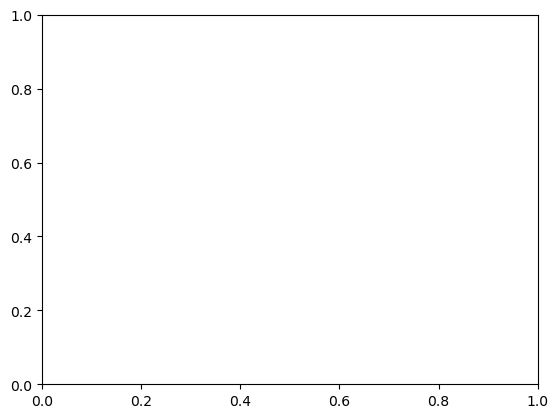

In [36]:
fig, ax = plt.subplots()
labels = ['1932-1936','1976-1981','1988-1993','2000-2005','2018-2022']

# Plot all points and trend-line
m,b,r = precipFlowLinReg(spring_p_stand_anom['__xarray_dataarray_variable__'], (ucrb_naturalized_streamflow['annual_flow_anom']))
x = [spring_p_stand_anom['__xarray_dataarray_variable__'].min(),spring_p_stand_anom['__xarray_dataarray_variable__'].max()]
y = [spring_p_stand_anom['__xarray_dataarray_variable__'].min()*m+b,spring_p_stand_anom['__xarray_dataarray_variable__'].max()*m+b]
ax.plot(x,y)
# ax.scatter(spring_p_stand_anom['__xarray_dataarray_variable__'], (ucrb_naturalized_streamflow['annual_flow_anom']), label=f'All years r2= {round(r**2,2)}')

# Plot drought periods and trend lines
for i,drought in enumerate([drought_1930s,drought_1970s,drought_1980s,drought_2000s,drought_2010s]):
    m,b,r = precipFlowLinReg(spring_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'], (ucrb_naturalized_streamflow.loc[drought]['annual_flow_anom']))
    x = [spring_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'].min(),spring_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'].max()]
    y = [spring_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'].min()*m+b,spring_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'].max()*m+b]
    ax.plot(x,y)
    ax.scatter(spring_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'], 
               (ucrb_naturalized_streamflow.loc[drought]['annual_flow_anom']),
               label=f'{labels[i]} r2= {round(r**2,2)}')

ax.legend()
ax.set_xlabel('Spring Precip Anomaly')
ax.set_ylabel('Annual Q Anomaly')
ax.set_title("Spring Precipitation Anomaly against \nNaturalized Streamflow at Lee's Ferry")



ax.legend()

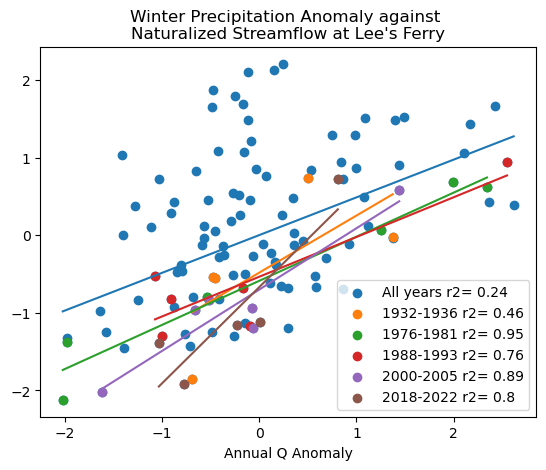

In [285]:
fig, ax = plt.subplots()
labels = ['1932-1936','1976-1981','1988-1993','2000-2005','2018-2022']

# Plot all points and trend-line
m,b,r = precipFlowLinReg(winter_p_stand_anom['__xarray_dataarray_variable__'], (ucrb_naturalized_streamflow['annual_flow_anom']))
x = [winter_p_stand_anom['__xarray_dataarray_variable__'].min(),winter_p_stand_anom['__xarray_dataarray_variable__'].max()]
y = [winter_p_stand_anom['__xarray_dataarray_variable__'].min()*m+b,winter_p_stand_anom['__xarray_dataarray_variable__'].max()*m+b]
ax.plot(x,y)
ax.scatter(winter_p_stand_anom['__xarray_dataarray_variable__'], (ucrb_naturalized_streamflow['annual_flow_anom']), label=f'All years r2= {round(r**2,2)}')

# Plot drought periods and trend lines
for i,drought in enumerate([drought_1930s,drought_1970s,drought_1980s,drought_2000s,drought_2010s]):
    m,b,r = precipFlowLinReg(winter_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'], (ucrb_naturalized_streamflow.loc[drought]['annual_flow_anom']))
    x = [winter_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'].min(),winter_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'].max()]
    y = [winter_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'].min()*m+b,winter_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'].max()*m+b]
    ax.plot(x,y)
    ax.scatter(winter_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'], 
               (ucrb_naturalized_streamflow.loc[drought]['annual_flow_anom']),
               label=f'{labels[i]} r2= {round(r**2,2)}')

ax.legend()
ax.set_xlabel('Winter Precip Anomaly')
ax.set_ylabel('Annual Q Anomaly')
ax.set_title("Winter Precipitation Anomaly against \nNaturalized Streamflow at Lee's Ferry")



ax.legend()

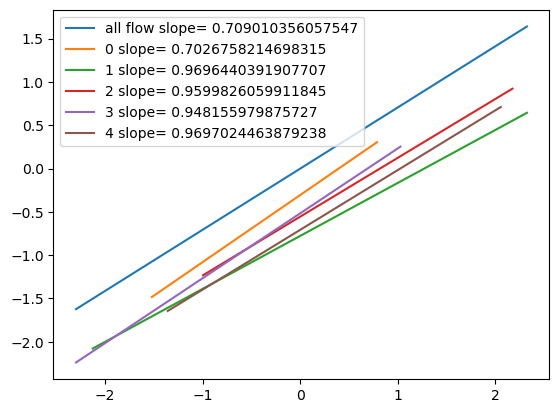

In [270]:
fig, ax = plt.subplots()
drought = ['1932-1936','1976-1981','1988-1993','2000-2005','2018-2022']
ax.scatter(winter_p_stand_anom['__xarray_dataarray_variable__'], (ucrb_naturalized_streamflow['annual_flow_anom']))
ax.scatter(winter_p_stand_anom.sel(WY=drought_1930s)['__xarray_dataarray_variable__'], (ucrb_naturalized_streamflow.loc[drought_1930s]['annual_flow_anom']),label=drought[i])
ax.scatter(winter_p_stand_anom.sel(WY=drought_1970s)['__xarray_dataarray_variable__'], (ucrb_naturalized_streamflow.loc[drought_1970s]['annual_flow_anom']),label=drought[i])
ax.scatter(winter_p_stand_anom.sel(WY=drought_1980s)['__xarray_dataarray_variable__'], (ucrb_naturalized_streamflow.loc[drought_1980s]['annual_flow_anom']),label=drought[i])
ax.scatter(winter_p_stand_anom.sel(WY=drought_2000s)['__xarray_dataarray_variable__'], (ucrb_naturalized_streamflow.loc[drought_2000s]['annual_flow_anom']),label=drought[i])
ax.scatter(winter_p_stand_anom.sel(WY=drought_2010s)['__xarray_dataarray_variable__'], (ucrb_naturalized_streamflow.loc[drought_2010s]['annual_flow_anom']),label=drought[i])
ax.legend()
ax.set_xlabel('Winter Precip Anomaly')
ax.set_xlabel('Q (Spring + Summer) Anomaly')
ax.set_title("Winter + Spring Precipitation Anomaly against \nNaturalized Streamflow at Lee's Ferry")


m,b,r = precipFlowLinReg(winter_spring_p_stand_anom['__xarray_dataarray_variable__'], (ucrb_naturalized_streamflow['annual_flow_anom']))
x = [winter_spring_p_stand_anom['__xarray_dataarray_variable__'].min(),winter_spring_p_stand_anom['__xarray_dataarray_variable__'].max()]
y = [winter_spring_p_stand_anom['__xarray_dataarray_variable__'].min()*m+b,winter_spring_p_stand_anom['__xarray_dataarray_variable__'].max()*m+b]
ax.plot(x,y, label=f'all flow slope= {r}')
for i,drought in enumerate([drought_1930s,drought_1970s,drought_1980s,drought_2000s,drought_2010s]):
    m,b,r = precipFlowLinReg(winter_spring_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'], (ucrb_naturalized_streamflow.loc[drought]['annual_flow_anom']))
    x = [winter_spring_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'].min(),winter_spring_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'].max()]
    y = [winter_spring_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'].min()*m+b,winter_spring_p_stand_anom.sel(WY=drought)['__xarray_dataarray_variable__'].max()*m+b]
    ax.plot(x,y, label=f'{i} slope= {r}')
ax.legend()

Interesting to note the change in slope in the more recent dry periods. It is significantly steeper. Now want to replicate this in other basins?